
# <center>Sendy Logistics</center>

Sendy is a business-to-business platform established in 2014, to enable businesses of all types and sizes to transport goods more efficiently across East Africa.

The company is headquartered in Kenya with a team of more than 100 staff, focused on building practical solutions for Africa’s dynamic transportation needs, from developing apps and web solutions, to providing dedicated support for goods on the move.

Currently operating in Kenya and Uganda, Sendy is expanding to Nigeria and Tanzania, to enable thousands more businesses to move volumes of goods easily, anywhere, at any time. Sendy aggregates a pool of delivery options from 28 ton, 14 ton, 5 ton trucks to pick up trucks, vans and motorcycles.

<p><img src="./image/Sendy-delivery-1200x500.jpg" alt="Sendy Logistics Logo"></p>


Sendy Logistics has realised that data is a critical component that can aid in building more efficient, affordable and accessible solutions as such they are interested in using data to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination. 

The solution will help Sendy enhance customer communication and the reliability of its service; which will ultimately improve customer experience. In addition, the solution will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business through improved resource management and planning for order scheduling.

To help Sendy achieve this goal we will build a predictive model that will predict estimated time of delivery of orders by looking at all factors that could influence the time from pick up to arrival of an order such as distance, date, the rider delivering the order etc.

## Importing the libraries ##
- We going to use the numpy libraries to use numpy arrays 
- We going to use pandas to load, merge  and modify our dataset
- matplotlib and seaborn libraries are going to be used to plot the model 

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

## Loading the dataset ##

- **Pandas** is used to load the datafiles into our workspace
- four datafiles were loaded named Riders, Test,Train as well as VariableDefinitions

- Train.csv contains  Sendy historic data of orders with 28 features, this is the data we will use to train our model
- Test.csv contains  Sendy historic data of orders with 24 features, this is the data we will use to test our model
- Riders.csv contains information of riders that make the deliveries


In [2]:
riders = pd.read_csv("./regression data/Riders.csv")
train = pd.read_csv("./regression data/Train.csv")
test = pd.read_csv("./regression data/Test.csv")

In [3]:
train.shape

(21201, 29)

In [4]:
test.shape

(7068, 25)

# Explore the data

Go over the datasets to get an understanding of the features involved and how they related to each other at an exploratory level. 

In [5]:
# Have a view of the first 5 columns of riders datatset.
riders.head()

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156


In [6]:
# Count the number of rows and columns for riders data
riders.shape

(960, 5)

In [7]:
# Have a view of the first 5 columns of the train datatset.
train.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [8]:
# Count the number of rows and columns for train data
train.shape

(21201, 29)

In [9]:
# Have a view of the first 5 columns of test datatset.
test.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [10]:
# Count the number of rows and columns for test data
test.shape

(7068, 25)

#### Key takeaways:
- The target column for modelling is the the "Time from Pickup to Arrival", which is rightfully in the train dataset.
- The train dataset has four extra columns, compared to the 25 that are in the test dataset. One of the four is the target column as expected, we may have to drop the other three.
- Riders dataset is not linked to the target variable, it will need to joined to train and test data by "Rider Id" column which is common in all three datasets.
- Train dataset has most observations at 21 201, followed by train data at 7 068 then riders at 960.
- There are missing values evident in the "Temperature" and "Precipitation in millimeters" columns, we will have to search and handle missing data. 

### Investigate the column name, datatype  and missing values in each column


In [11]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rider Id        960 non-null    object 
 1   No_Of_Orders    960 non-null    int64  
 2   Age             960 non-null    int64  
 3   Average_Rating  960 non-null    float64
 4   No_of_Ratings   960 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 37.6+ KB


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              7068 non-null   object 
 1   User Id                               7068 non-null   object 
 2   Vehicle Type                          7068 non-null   object 
 3   Platform Type                         7068 non-null   int64  
 4   Personal or Business                  7068 non-null   object 
 5   Placement - Day of Month              7068 non-null   int64  
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64  
 7   Placement - Time                      7068 non-null   object 
 8   Confirmation - Day of Month           7068 non-null   int64  
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64  
 10  Confirmation - Time                   7068 non-null   object 
 11  Arrival at Pickup

#### Key notes:
- The riders data is in good standing. 
- Additional columns in the train dataset; relative to test data, are "Arrival at Destination - Day of Month", "Arrival at Destination - Weekday (Mo = 1)", "Arrival at Destination - Time" and traget variable "Time from Pickup to Arrival".
- As indicated, it is only the "Temperature" and "Precipitation in millimeters" columns that have missing data. These will need to be handled in the cleaning process.
- Some columns are in "object" datatype, we will need to keep this in mind when choosing our variables for regression models.

### Check descriptive statistics of the datasets

In [14]:
riders.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
No_Of_Orders,960.0,1864.851042,1880.337785,2.0,261.75,1475.5,2847.25,9756.0
Age,960.0,1200.234375,810.930171,96.0,478.25,1021.0,1891.50,3764.0
Average_Rating,960.0,13.412604,2.675794,0.0,13.50,14.0,14.30,15.2
No_of_Ratings,960.0,427.983333,486.957931,0.0,30.00,223.0,678.75,2298.0


In [15]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Platform Type,21201.0,2.752182,0.625178,1.000000,3.000000,3.000000,3.000000,4.000000
Placement - Day of Month,21201.0,15.653696,8.798916,1.000000,8.000000,15.000000,23.000000,31.000000
Placement - Weekday (Mo = 1),21201.0,3.240083,1.567295,1.000000,2.000000,3.000000,5.000000,7.000000
Confirmation - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Confirmation - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Arrival at Pickup - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Arrival at Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Pickup - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000
Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.000000,2.000000,3.000000,5.000000,7.000000
Arrival at Destination - Day of Month,21201.0,15.653837,8.798886,1.000000,8.000000,15.000000,23.000000,31.000000


#### Observations:
- The notable high difference between the 75th precentile and the max value suggests the presence of outliers [e.g. "No_Of_Orders" and "No_Of_Ratings" in the riders dataset]
- Mean, median and standard deviation vary significantly across all columns.


### Explore column-to-column relations 
To use linear regression for modelling,its necessary to remove features that are correlated to each other. It is good to get a glimpse of which features are strongly correlated at an expoloatory level. Let's have a look:

In [16]:
#plotting heatmap for overall data set before cleaning the data

sns.heatmap(train.corr(), square=True, annot = False)

<IPython.core.display.Javascript object>

#### Observations:
- It is notable that the target variable ("Time from Pickup to Arrival") has a fairly strong positive correlation to "Distance(KM)" at around 50-60%, followed by weakened correlation to other predictor variables. 


In [17]:
test.shape

(7068, 25)

In [18]:
train.shape

(21201, 29)

### Merge riders to test and train data

In [19]:
# merging train with riders and test with riders on 'Rider id'
merged_train = pd.merge(train, riders, on="Rider Id", how="left").copy()
merged_test = pd.merge(test, riders, on="Rider Id", how="left").copy()

In [20]:
merged_train.shape

(21201, 33)

In [21]:
merged_test.shape

(7068, 29)

In [22]:
merged_train.isnull().sum()

Order No                                         0
User Id                                          0
Vehicle Type                                     0
Platform Type                                    0
Personal or Business                             0
Placement - Day of Month                         0
Placement - Weekday (Mo = 1)                     0
Placement - Time                                 0
Confirmation - Day of Month                      0
Confirmation - Weekday (Mo = 1)                  0
Confirmation - Time                              0
Arrival at Pickup - Day of Month                 0
Arrival at Pickup - Weekday (Mo = 1)             0
Arrival at Pickup - Time                         0
Pickup - Day of Month                            0
Pickup - Weekday (Mo = 1)                        0
Pickup - Time                                    0
Arrival at Destination - Day of Month            0
Arrival at Destination - Weekday (Mo = 1)        0
Arrival at Destination - Time  

# Data Preprocessing 

## Identifying and handling missing values in train data

We see that only two columns contain missing values.
<br> Temperature column has 4366 missing values while Precipitation in millimeters has 20649.
We can fill the missing values in the Temperature column with the mean of the temperatures.


In [23]:
# Filling the missing values in values Temperature column with the on both the train and test data
merged_train['Temperature'] = merged_train['Temperature'].fillna( merged_train['Temperature'].mean())
merged_test['Temperature'] = merged_test['Temperature'].fillna( merged_test['Temperature'].mean())

## Investigating the missing values in Precipitation in millimeters column

In [24]:
# Proportion of missing values in the Precipitation in millimeters column
missing_vals = merged_train['Precipitation in millimeters'].isnull().sum()
round((missing_vals/len(merged_train.index))*100,0)

97.0

### 97% of the records on the Precipitation in millimeters column have missing values
That is only 552 records have values, so we analyse these 552 records we have

In [25]:
precipitation = merged_train['Precipitation in millimeters'].copy()
precipitation.dropna(inplace = True)

# We want to check if whether the available records we have contain Zeros for when 
# there was no rainfall/precipitation at the time of the delivery.
precipitation[precipitation==0].count()

0

We see that on the 552 records that we have non of them contain Zeros for whent here was no precipitation as such we believe that the missing values in this column actually suggest that there was no precipitation at the time the deliveries, as such we fill the missing values with Zeros

In [26]:
# Filling missing values in Precipitation column with 0 on both train and test data
merged_train['Precipitation in millimeters'] = merged_train['Precipitation in millimeters'].fillna(0)
merged_test['Precipitation in millimeters'] = merged_test['Precipitation in millimeters'].fillna(0)

In [27]:
# Checking if all missing values have been handled
merged_train.isnull().sum()

Order No                                     0
User Id                                      0
Vehicle Type                                 0
Platform Type                                0
Personal or Business                         0
Placement - Day of Month                     0
Placement - Weekday (Mo = 1)                 0
Placement - Time                             0
Confirmation - Day of Month                  0
Confirmation - Weekday (Mo = 1)              0
Confirmation - Time                          0
Arrival at Pickup - Day of Month             0
Arrival at Pickup - Weekday (Mo = 1)         0
Arrival at Pickup - Time                     0
Pickup - Day of Month                        0
Pickup - Weekday (Mo = 1)                    0
Pickup - Time                                0
Arrival at Destination - Day of Month        0
Arrival at Destination - Weekday (Mo = 1)    0
Arrival at Destination - Time                0
Distance (KM)                                0
Temperature  

In [28]:
# Checking missing values in merged_test
merged_test.isnull().sum()

Order No                                0
User Id                                 0
Vehicle Type                            0
Platform Type                           0
Personal or Business                    0
Placement - Day of Month                0
Placement - Weekday (Mo = 1)            0
Placement - Time                        0
Confirmation - Day of Month             0
Confirmation - Weekday (Mo = 1)         0
Confirmation - Time                     0
Arrival at Pickup - Day of Month        0
Arrival at Pickup - Weekday (Mo = 1)    0
Arrival at Pickup - Time                0
Pickup - Day of Month                   0
Pickup - Weekday (Mo = 1)               0
Pickup - Time                           0
Distance (KM)                           0
Temperature                             0
Precipitation in millimeters            0
Pickup Lat                              0
Pickup Long                             0
Destination Lat                         0
Destination Long                  

In [29]:
merged_train.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival', 'No_Of_Orders', 'Age', 'Average_Rating',
       'No_of_Ratings'],
      dtype='object')

In [30]:
merged_test.columns

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Precipitation in millimeters',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings'],
      dtype='object')

In [31]:
# Alignment of Dataset

merged_train = merged_train[['Order No', 'User Id', 'Vehicle Type',
       'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Precipitation in millimeters',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id', 'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings',
       'Time from Pickup to Arrival']]  


In [32]:
merged_train.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,1637,1309,13.8,549,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,396,339,13.6,69,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,1023,242,12.5,114,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,886,283,14.5,113,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,2311,872,14.1,533,1214


In [33]:
# Investigated the merged data

merged_train.hist(bins=60, figsize=(20,15))


<IPython.core.display.Javascript object>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BEEB1BE5C8>,
      dtype=object)

#### Key observations:
- Platform type 3 is the most prefered.
- Placement, confirmation and pickup day of the month indicates that majority of orders are made at the beginning and towards the end of the month.
- These orders are mainly made on weekdays as shown by weekday data. 
- Distance data is postively skewed, majority of orders are at short distance. Peaking at around 2000 for 6-7 kilometers.
- Temperature is normal distributed, with an expected peak around the mean as we resolved the missing values by mean.
- As expected, the precipitations follows the same trend as temperature, indicating a peak around the value we resolved the missing values by. In this case, it is zero. 
- Latitutides and longitutes are more centered around the mean. 
- No. of orders, Age and No. of ratings indicates positive skewness with an evidence of outliers. 
- Drivers received ratings between 12 and 15.
- All in all, the target variable is positively skewed, with majority of driveriver arriving at the destination within 23 min from the pickup point.

## Variable Selection by correlation and significance ##

- We have more predictor variables to choose from, so we need a way of guiding us to choose the best ones to be our predictors. One way is to look at the correlations between the Time from Pickup to Arrival and each variables in our DataFrame and select those with the strongest correlations (both positive and negative).

- We also need to consider how significant those features are.

- The code below will create a new DataFrame and store the correlation coefficents and p-values in that DataFrame

In [34]:
# Calculate correlations between predictor variables and the response variable
corrs = merged_train .corr()['Time from Pickup to Arrival'].sort_values(ascending=False)
corrs

Time from Pickup to Arrival             1.000000
Distance (KM)                           0.580608
Destination Long                        0.070425
Pickup Long                             0.060285
Confirmation - Weekday (Mo = 1)         0.009744
Arrival at Pickup - Weekday (Mo = 1)    0.009744
Pickup - Weekday (Mo = 1)               0.009744
Placement - Weekday (Mo = 1)            0.009693
Temperature                             0.005772
No_of_Ratings                           0.005609
Precipitation in millimeters            0.005495
Platform Type                          -0.003827
Age                                    -0.007969
Pickup - Day of Month                  -0.014701
Arrival at Pickup - Day of Month       -0.014701
Confirmation - Day of Month            -0.014701
Placement - Day of Month               -0.014710
No_Of_Orders                           -0.041608
Average_Rating                         -0.042559
Pickup Lat                             -0.053823
Destination Lat     

In [35]:
# Visualize the correlation

sns.heatmap(merged_train.corr(), square=True, annot = False)


<IPython.core.display.Javascript object>

#### Observations:
- There exists a fairly strong relationship between merged predictor variables; however, this has not affected the initial observation much in relation to the target variable.
- We will investigate the correlation further using the p-values.

In [36]:
# Build a dictionary of correlation coefficients and p-values
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'Time from Pickup to Arrival']
for col in column_titles:
    p_val = round(pearsonr(merged_train [col], merged_train ['Time from Pickup to Arrival'])[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}

df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted[df_cp_sorted['P_Value']<0.1]

,Correlation_Coefficient,P_Value
Distance (KM),0.580608,0.000000
Average_Rating,-0.042559,0.000000
No_Of_Orders,-0.041608,0.000000
Pickup Lat,-0.053823,0.000000
Destination Lat,-0.061872,0.000000
Pickup Long,0.060285,0.000000
Destination Long,0.070425,0.000000
Placement - Day of Month,-0.014710,0.032205
Pickup - Day of Month,-0.014701,0.032312
Arrival at Pickup - Day of Month,-0.014701,0.032312


- on the heatmap above we can see a lot of variables being highly corelated with each other 
- We are dropping all the predictors that are highly correlated with each other based on the heat map above

In [37]:

#dropping highly correlated predictors and the ones that were not selected above

merged_train = merged_train.drop(['Placement - Weekday (Mo = 1)', 'Placement - Weekday (Mo = 1)','Confirmation - Day of Month','Confirmation - Weekday (Mo = 1)','Arrival at Pickup - Day of Month','Arrival at Pickup - Weekday (Mo = 1)','Pickup - Day of Month','Pickup - Weekday (Mo = 1)',
                                  'No_of_Ratings','No_Of_Orders','Average_Rating'], axis = 1)

merged_test = merged_test.drop(['Placement - Weekday (Mo = 1)', 'Placement - Weekday (Mo = 1)','Confirmation - Day of Month','Confirmation - Weekday (Mo = 1)','Arrival at Pickup - Day of Month','Arrival at Pickup - Weekday (Mo = 1)','Pickup - Day of Month','Pickup - Weekday (Mo = 1)',
                                'No_of_Ratings','No_Of_Orders','Average_Rating'], axis = 1)


#dropping the irrelevant columns 
merged_train = merged_train.drop(['User Id','Vehicle Type','Rider Id',
                                  'Confirmation - Time', ], axis = 1)

merged_test = merged_test.drop(['User Id','Vehicle Type','Rider Id', 
                                'Confirmation - Time'], axis = 1)


merged_train.head()



,Order No,Platform Type,Personal or Business,Placement - Day of Month,Placement - Time,Arrival at Pickup - Time,Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age,Time from Pickup to Arrival
0,Order_No_4211,3,Business,9,9:35:46 AM,10:04:47 AM,10:27:30 AM,4,20.400000,0.0,-1.317755,36.830370,-1.300406,36.829741,1309,745
1,Order_No_25375,3,Personal,12,11:16:16 AM,11:40:22 AM,11:44:09 AM,16,26.400000,0.0,-1.351453,36.899315,-1.295004,36.814358,339,1993
2,Order_No_1899,3,Business,30,12:39:25 PM,12:49:34 PM,12:53:03 PM,3,23.258889,0.0,-1.308284,36.843419,-1.300921,36.828195,242,455
3,Order_No_9336,3,Business,15,9:25:34 AM,9:37:56 AM,9:43:06 AM,9,19.200000,0.0,-1.281301,36.832396,-1.257147,36.795063,283,1341
4,Order_No_27883,1,Personal,13,9:55:18 AM,10:03:53 AM,10:05:23 AM,9,15.400000,0.0,-1.266597,36.792118,-1.295041,36.809817,872,1214


### Copy datasets

In [38]:
merged_train_copy = merged_train.copy()
merged_test_copy = merged_train.copy()

In [39]:
merged_train.columns

Index(['Order No', 'Platform Type', 'Personal or Business',
       'Placement - Day of Month', 'Placement - Time',
       'Arrival at Pickup - Time', 'Pickup - Time', 'Distance (KM)',
       'Temperature', 'Precipitation in millimeters', 'Pickup Lat',
       'Pickup Long', 'Destination Lat', 'Destination Long', 'Age',
       'Time from Pickup to Arrival'],
      dtype='object')

In [40]:
merged_test.columns

Index(['Order No', 'Platform Type', 'Personal or Business',
       'Placement - Day of Month', 'Placement - Time',
       'Arrival at Pickup - Time', 'Pickup - Time', 'Distance (KM)',
       'Temperature', 'Precipitation in millimeters', 'Pickup Lat',
       'Pickup Long', 'Destination Lat', 'Destination Long', 'Age'],
      dtype='object')

In [41]:
merged_train.drop(['Placement - Time','Arrival at Pickup - Time','Pickup - Time','Order No'], axis = 1, inplace = True)
merged_test.drop(['Placement - Time','Arrival at Pickup - Time','Pickup - Time','Order No'], axis = 1, inplace = True)

In [42]:
merged_train_copy = merged_train.copy()

In [43]:
merged_train_copy.head()

,Platform Type,Personal or Business,Placement - Day of Month,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age,Time from Pickup to Arrival
0,3,Business,9,4,20.400000,0.0,-1.317755,36.830370,-1.300406,36.829741,1309,745
1,3,Personal,12,16,26.400000,0.0,-1.351453,36.899315,-1.295004,36.814358,339,1993
2,3,Business,30,3,23.258889,0.0,-1.308284,36.843419,-1.300921,36.828195,242,455
3,3,Business,15,9,19.200000,0.0,-1.281301,36.832396,-1.257147,36.795063,283,1341
4,1,Personal,13,9,15.400000,0.0,-1.266597,36.792118,-1.295041,36.809817,872,1214


In [44]:
merged_test.head(2)

,Platform Type,Personal or Business,Placement - Day of Month,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age
0,3,Business,27,8,23.24612,0.0,-1.333275,36.870815,-1.305249,36.822390,1511
1,3,Business,17,5,23.24612,0.0,-1.272639,36.794723,-1.277007,36.823907,273


In [45]:
merged_test_copy =merged_test.copy()

In [46]:
merged_train_copy.head()

,Platform Type,Personal or Business,Placement - Day of Month,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age,Time from Pickup to Arrival
0,3,Business,9,4,20.400000,0.0,-1.317755,36.830370,-1.300406,36.829741,1309,745
1,3,Personal,12,16,26.400000,0.0,-1.351453,36.899315,-1.295004,36.814358,339,1993
2,3,Business,30,3,23.258889,0.0,-1.308284,36.843419,-1.300921,36.828195,242,455
3,3,Business,15,9,19.200000,0.0,-1.281301,36.832396,-1.257147,36.795063,283,1341
4,1,Personal,13,9,15.400000,0.0,-1.266597,36.792118,-1.295041,36.809817,872,1214


In [47]:
merged_test_copy.head()

,Platform Type,Personal or Business,Placement - Day of Month,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age
0,3,Business,27,8,23.24612,0.0,-1.333275,36.870815,-1.305249,36.822390,1511
1,3,Business,17,5,23.24612,0.0,-1.272639,36.794723,-1.277007,36.823907,273
2,3,Business,27,5,22.80000,0.0,-1.290894,36.822971,-1.276574,36.851365,460
3,3,Business,17,5,24.50000,0.0,-1.290503,36.809646,-1.303382,36.790658,560
4,3,Business,11,6,24.40000,0.0,-1.281081,36.814423,-1.266467,36.792161,1120


In [48]:
merged_test.head()

,Platform Type,Personal or Business,Placement - Day of Month,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age
0,3,Business,27,8,23.24612,0.0,-1.333275,36.870815,-1.305249,36.822390,1511
1,3,Business,17,5,23.24612,0.0,-1.272639,36.794723,-1.277007,36.823907,273
2,3,Business,27,5,22.80000,0.0,-1.290894,36.822971,-1.276574,36.851365,460
3,3,Business,17,5,24.50000,0.0,-1.290503,36.809646,-1.303382,36.790658,560
4,3,Business,11,6,24.40000,0.0,-1.281081,36.814423,-1.266467,36.792161,1120



## Encoding the categorical data ##
 - Bussiness column needs to be encoded into dummy variables  so i can be of type int 


In [49]:
merged_train.head()

,Platform Type,Personal or Business,Placement - Day of Month,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age,Time from Pickup to Arrival
0,3,Business,9,4,20.400000,0.0,-1.317755,36.830370,-1.300406,36.829741,1309,745
1,3,Personal,12,16,26.400000,0.0,-1.351453,36.899315,-1.295004,36.814358,339,1993
2,3,Business,30,3,23.258889,0.0,-1.308284,36.843419,-1.300921,36.828195,242,455
3,3,Business,15,9,19.200000,0.0,-1.281301,36.832396,-1.257147,36.795063,283,1341
4,1,Personal,13,9,15.400000,0.0,-1.266597,36.792118,-1.295041,36.809817,872,1214


In [50]:
merged_test.head()

,Platform Type,Personal or Business,Placement - Day of Month,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age
0,3,Business,27,8,23.24612,0.0,-1.333275,36.870815,-1.305249,36.822390,1511
1,3,Business,17,5,23.24612,0.0,-1.272639,36.794723,-1.277007,36.823907,273
2,3,Business,27,5,22.80000,0.0,-1.290894,36.822971,-1.276574,36.851365,460
3,3,Business,17,5,24.50000,0.0,-1.290503,36.809646,-1.303382,36.790658,560
4,3,Business,11,6,24.40000,0.0,-1.281081,36.814423,-1.266467,36.792161,1120


In [51]:
merged_train= pd.get_dummies(merged_train, drop_first=True)
merged_test = pd.get_dummies(merged_test, drop_first=True)

In [52]:
merged_train.head()

,Platform Type,Placement - Day of Month,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age,Time from Pickup to Arrival,Personal or Business_Personal
0,3,9,4,20.400000,0.0,-1.317755,36.830370,-1.300406,36.829741,1309,745,0
1,3,12,16,26.400000,0.0,-1.351453,36.899315,-1.295004,36.814358,339,1993,1
2,3,30,3,23.258889,0.0,-1.308284,36.843419,-1.300921,36.828195,242,455,0
3,3,15,9,19.200000,0.0,-1.281301,36.832396,-1.257147,36.795063,283,1341,0
4,1,13,9,15.400000,0.0,-1.266597,36.792118,-1.295041,36.809817,872,1214,1


In [53]:
merged_test.head()

,Platform Type,Placement - Day of Month,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age,Personal or Business_Personal
0,3,27,8,23.24612,0.0,-1.333275,36.870815,-1.305249,36.822390,1511,0
1,3,17,5,23.24612,0.0,-1.272639,36.794723,-1.277007,36.823907,273,0
2,3,27,5,22.80000,0.0,-1.290894,36.822971,-1.276574,36.851365,460,0
3,3,17,5,24.50000,0.0,-1.290503,36.809646,-1.303382,36.790658,560,0
4,3,11,6,24.40000,0.0,-1.281081,36.814423,-1.266467,36.792161,1120,0


# Base Model

In [54]:
merged_test.head()

,Platform Type,Placement - Day of Month,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Age,Personal or Business_Personal
0,3,27,8,23.24612,0.0,-1.333275,36.870815,-1.305249,36.822390,1511,0
1,3,17,5,23.24612,0.0,-1.272639,36.794723,-1.277007,36.823907,273,0
2,3,27,5,22.80000,0.0,-1.290894,36.822971,-1.276574,36.851365,460,0
3,3,17,5,24.50000,0.0,-1.290503,36.809646,-1.303382,36.790658,560,0
4,3,11,6,24.40000,0.0,-1.281081,36.814423,-1.266467,36.792161,1120,0


In [55]:
X = merged_train.drop(['Time from Pickup to Arrival','Age'], axis = 1)
X_test = merged_test.drop(['Age'],axis = 1)
y = np.array(train['Time from Pickup to Arrival']).reshape(-1,1)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.30,
                                                  random_state = 25)


In [58]:
lin_reg = LinearRegression() lin_reg.fit(X_train,y_train)

SyntaxError: invalid syntax (<ipython-input-58-0930e0c2a46e>, line 1)

In [ ]:
val_pred = lin_reg.predict(X_val)
val_pred

In [ ]:
# function that calculates the root mean squared error
def rmse(y_test,y_prediction):
    result = np.sqrt(mean_squared_error(y_test,y_prediction))
    return result

In [ ]:
rmse(y_val, val_pred)

In [ ]:
# Making actual y predictions
y_pred = lin_reg.predict(X_test)

In [ ]:
submission = test[['Order No']].copy()
submission['Time from Pickup to Arrival'] = y_pred

In [ ]:
submission

In [ ]:
# submission.to_csv('submission_0.11.csv', index = False)

# Feature Scaling ##

One of the important reason of feature scaling is so that one significant number doesn't impact the model because of their large magnitude. Thus, feature scaling is one of the most critical step in machine learning during the preprocessing data before creating the a machine learning model. There are several techniques of scaling and the one used in this work is known as Normalization. Normally this technique is used when we want to bound the values between two numbers, that are often between 0 to 1, or -1 to 1. The diagram below shows how the data looks like after it has been scaling it in the X-Y plane.

![image.png](attachment:image.png)

In [ ]:
# Import the """MIN MAX SCALER"""
from sklearn.preprocessing import  MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
train_df.columns

NameError: ignored

In [ ]:
# Here the Features: Day of the Month, Distance, Temp, Precipitation (mm), Time for Pick up Arrival are picked 
# ... from the train data available. 
# Then, they are scaled and represented in a new Dataframe : df_train
df_train = pd.DataFrame(scaler.fit_transform(train_df[['Placement - Day of Month',
                                               'Distance (KM)', 'Temperature', 
                                               'Precipitation in millimeters', 'Time from Pickup to Arrival' ]]),
                   columns = ['Day of Month', 'Distance (km)', 'Temp', 'Precipitation (mm)', 'Pickup to Arrival (s)' ])

In [ ]:
df_train.head()

,Day of Month,Distance (km),Temp,Precipitation (mm),Pickup to Arrival (s)
0,0.266667,0.062500,0.440191,0.0,0.094392
1,0.366667,0.312500,0.727273,0.0,0.252728
2,0.966667,0.041667,0.576980,0.0,0.057600
3,0.466667,0.166667,0.382775,0.0,0.170008
4,0.400000,0.166667,0.200957,0.0,0.153895


We should als note that even if we only scale the independent variables, we get a similar plot of both sclaed X-Y axis.

In [ ]:
# Here the Features: Day of the Month, Distance, Temp, Precipitation (mm) are picked 
# ... from the train data available. 
# Then, they are scaled and represented in a new Dataframe : df2_train
df2_train = pd.DataFrame(scaler.fit_transform(train[['Placement - Day of Month',
                                               'Distance (KM)', 'Temperature', 
                                               'Precipitation in millimeters']]),
                   columns = ['Day of Month', 'Distance (km)', 'Temp', 'Precipitation (mm)'])
df2_test = pd.DataFrame(scaler.fit_transform(test[['Placement - Day of Month',
                                               'Distance (KM)', 'Temperature', 
                                               'Precipitation in millimeters']]),
                   columns = ['Day of Month', 'Distance (km)', 'Temp', 'Precipitation (mm)'])

In [ ]:
# df2_train represents the independent variables that are scaled for this work. 
df2_train.head()

,Day of Month,Distance (km),Temp,Precipitation (mm)
0,0.266667,0.062500,0.440191,0.0
1,0.366667,0.312500,0.727273,0.0
2,0.966667,0.041667,0.576980,0.0
3,0.466667,0.166667,0.382775,0.0
4,0.400000,0.166667,0.200957,0.0


In [ ]:
df2_test.head()

,Day of Month,Distance (km),Temp,Precipitation (mm)
0,0.866667,0.152174,0.531541,0.0
1,0.533333,0.086957,0.531541,0.0
2,0.866667,0.086957,0.507937,0.0
3,0.533333,0.086957,0.597884,0.0
4,0.333333,0.108696,0.592593,0.0


## Creating y and x metrics ##

In [ ]:
# Below are the plot with X-Y metrics scaled. 
fig, axs = plt.subplots(2, 2, figsize=(9,7))

axs[0,0].scatter(df_train['Day of Month'], df_train['Pickup to Arrival (s)'], color = 'black')
axs[0,0].title.set_text('Day of Month vs. Pickup to Arrival (s)')

axs[0,1].scatter(df_train['Distance (km)'], df_train['Pickup to Arrival (s)'], color = 'black')
axs[0,1].title.set_text('Distance (km) vs. Pickup to Arrival (s)')

axs[1,0].scatter(df_train['Temp'],df_train['Pickup to Arrival (s)'], color = 'black')
axs[1,0].title.set_text('Temperature vs. Pickup to Arrival (s)')

axs[1,1].scatter(df_train['Precipitation (mm)'], df_train['Pickup to Arrival (s)'], color = 'black')
axs[1,1].title.set_text('Precipitation (mm) vs. Pickup to Arrival (s)')

fig.tight_layout(pad=3.0)

plt.show()

# The Day of Month, Distance (km), Temp and precipitation represents the predictor, whereas, the Pickup 
# ... to Arrival is the response. 

<IPython.core.display.Javascript object>

NameError: ignored

<IPython.core.display.Javascript object>


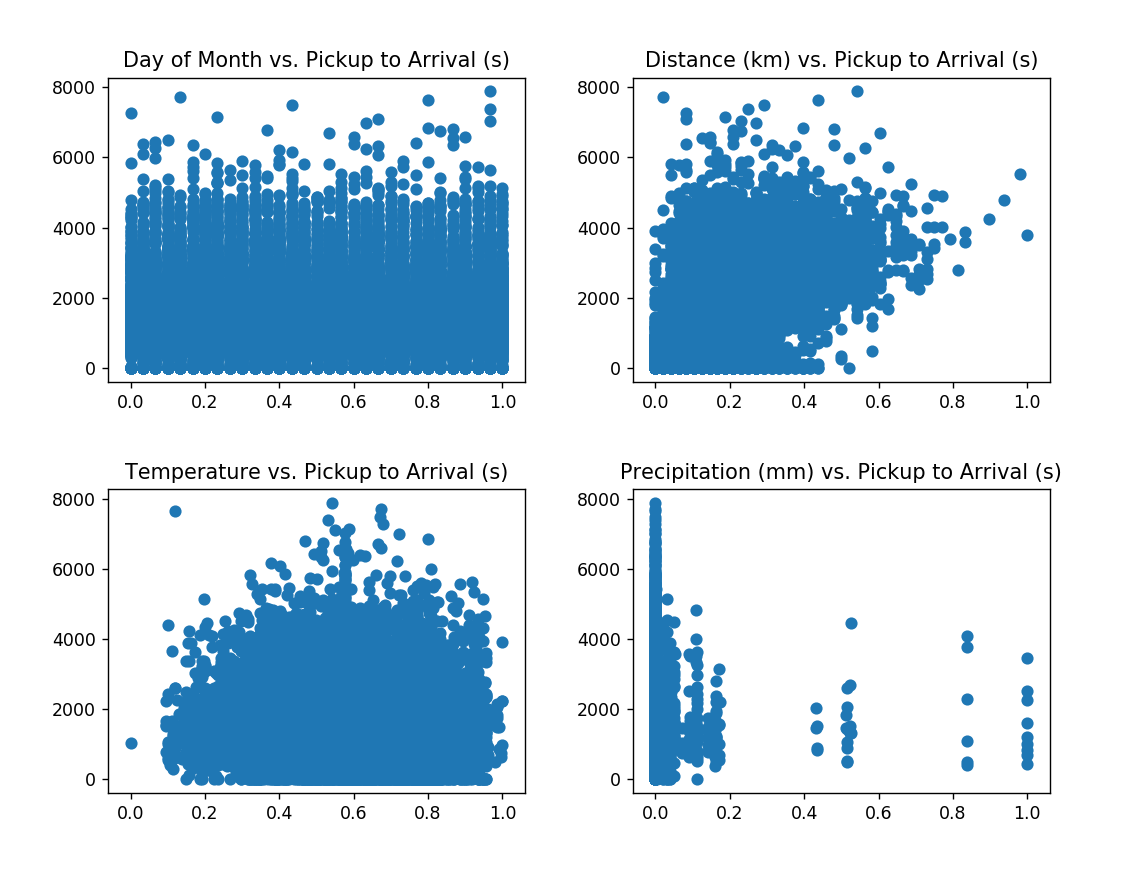

In [ ]:
# These are the plots with with only the independent variables are scaled. 
fig, axs = plt.subplots(2, 2, figsize=(9,7))

axs[0,0].scatter(df_train['Day of Month'], train['Time from Pickup to Arrival'])
axs[0,0].title.set_text('Day of Month vs. Pickup to Arrival (s)')

axs[0,1].scatter(df_train['Distance (km)'], train['Time from Pickup to Arrival'])
axs[0,1].title.set_text('Distance (km) vs. Pickup to Arrival (s)')

axs[1,0].scatter(df_train['Temp'], train['Time from Pickup to Arrival'])
axs[1,0].title.set_text('Temperature vs. Pickup to Arrival (s)')

axs[1,1].scatter(df_train['Precipitation (mm)'], train['Time from Pickup to Arrival'])
axs[1,1].title.set_text('Precipitation (mm) vs. Pickup to Arrival (s)')

fig.tight_layout(pad=3.0)

plt.show()

# The Day of Month, Distance (km), Temp and precipitation represents the predictor, whereas, the Pickup 
# ... to Arrival is the response (not scaled).

In [ ]:
# split predictors and response

# Scaled predictors
x_month  = df_train['Day of Month']
x_distance = df_train['Distance (km)']
x_temp = df_train['Temp']
x_prec = df_train['Precipitation (mm)']

# The predicted response:
y_pa = train['Time from Pickup to Arrival']
# The unpredicted response:
y_pa_scale = df_train['Pickup to Arrival (s)']

# Model with scaled data version 0.2

In [ ]:
# Scalled datasets
#df2_train
# df2_test

In [ ]:
# Creating X and y metrics
X = df2_train.copy()
y = np.array(train_df['Time from Pickup to Arrival']).reshape(-1,1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.3, random_state = 23)

In [ ]:
# training the model
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
val_pred = lin_reg.predict(X_val)

In [ ]:
# Checking the root mean square error
rmse(y_val, val_pred)

828.9786142267769

In [ ]:
# actual y_predictions
X_test = df2_test

In [ ]:
y_pred = lin_reg.predict(X_test)

In [ ]:
submission_scaled_data = test[['Order No']].copy()
submission_scaled_data['Time from Pickup to Arrival'] = y_pred

submission_scaled_data

,Order No,Time from Pickup to Arrival
0,Order_No_19248,1405.545337
1,Order_No_12736,1112.339636
2,Order_No_768,1088.639682
3,Order_No_15332,1114.426323
4,Order_No_21373,1233.422165
...,...,...
7063,Order_No_3612,1137.883107
7064,Order_No_7657,2932.406166
7065,Order_No_1969,1669.912584
7066,Order_No_10591,2455.420186


In [ ]:
submission_scaled_data.to_csv('submission_scaled_data_0.2.csv', index = False)

In [ ]:
# Creating X and y metrics
X = train_df.drop(['Time from Pickup to Arrival','Order No'], axis = 1)
y = np.array(train_df['Time from Pickup to Arrival']).reshape(-1,1)
X_test = test_df.drop(['Order No'], axis =1)

## Spliting Data into the training and the validation set ##

In [ ]:
# Splitting the data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.30,
                                                  random_state = 25)

## Scaling the data and creating scaled train and scaled test data

In [ ]:
# creating instance for scaled X and  scaled y
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X)
y_scaled = sc_y.fit_transform(y)

In [ ]:
# splitting X and y of the scaled data
X_train_sc, X_val_sc, y_train_sc, y_val_sc = train_test_split(X_scaled,y_scaled,test_size = 0.3)

# Building Models

## Linear Model

In [ ]:
# Training a multiple Linear Training model
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

In [ ]:
# Making predicitions for the validation dataset
val_pred = lin_reg.predict(X_val)
val_pred

In [106]:
# function that calculates the root mean squared error
def rmse(y_test,y_prediction):
    result = np.sqrt(mean_squared_error(y_test,y_prediction))
    return result

In [ ]:
# calculate accuracy of validation predictions using root mean squared error
rmse(y_val, val_pred)

In [ ]:
plt.scatter(y_val,val_pred) 
plt.plot(y_val,y_val,"r") # perfect model line
plt.ylabel("Predicted $y$")
plt.xlabel("Actual $y$")
plt.show()

In [ ]:
# Making actual y predictions
y_pred = lin_reg.predict(X_test)

In [ ]:
submission = test[['Order No']].copy()
submission['Time from Pickup to Arrival'] = y_pred

In [ ]:
submission

## Comparing models


In [115]:
def best_perfomance(model_result,best_result):
    ''' This functions checks if whether the last model we build perfoms better compared our
    best perfoming models by comparing their RMSE score'''
    if model_result < best_result:
        print('This is now the best perfoming model, with RMSE of {}'.format(model_result))
    
    elif model_result == best_result:
        print('This model performance just as good as the previous best performing model with RMSE of {}'.format(model_result))
        
    else:
        print('This model performs poorly compared the previous best performing model')
        print('Best perfomaning model score: {}'.format(round(best_result,4)))
        print('Model result : {}'.format(round(model_result,4)))
        

In [ ]:
best_result = 793.3028821523337
model_result = rmse(y_val,val_pred)

In [ ]:
best_perfomance(model_result, best_result)

## Catboost Regressor

instal Catboost Regressor

In [ ]:
# creating an instance of the catboostregressor
cbr_model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)

NameError: ignored

In [ ]:
# training the catboost regressor model
cbr_model.fit(X_train, y_train)

NameError: ignored

In [ ]:
# predictions on the validation set
val_pred = cbr_model.predict(X_val)
val_pred

In [ ]:
model_result = rmse(y_val, val_pred)

In [ ]:
Checking the model performance
best_perfomance(model_result, best_result)

## Random Forest Regressor

In [ ]:
# creating a random forest regressor instancce
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [ ]:
# train the model
regr.fit(X_train, y_train)

In [ ]:
# making prdictions for the valdiation set
regr.predict(X_val)

In [ ]:
model_result = rmse(y_val,regr.predict(X_val))

In [ ]:
best_perfomance(model_result, best_result)

## Decision Tree Regressor

In [ ]:
# creating an instance of the DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state = 0)

In [ ]:
# training the model
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
# prediction of the validation set
tree_model.predict(X_val)

array([1188., 2157., 2270., ..., 1126.,  773., 1236.])

In [ ]:
model_result = rmse(y_val, tree_model.predict(X_val))

In [ ]:
best_perfomance(model_result, best_result)

This model performs poorly compared the previous best performing model
Best perfomaning model score: 793.3029
Model result : 1107.6072


## Support Vector Regression

In [ ]:
# creating instance for scaled X and  scaled y
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X)
y_scaled = sc_y.fit_transform(y)


In [ ]:
# splitting the scaled data in to training set and validation set
X_train_sc, X_val_sc, y_train_sc, y_val_sc = train_test_split(X_scaled,y_scaled,test_size = 0.3)

In [ ]:
# Training the SVR model
regressor_svr = SVR(kernel = 'rbf')
regressor_svr.fit(X_train_sc, y_train_sc)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
# making preditions on the validation test
val_pred = sc_y.inverse_transform(regressor_svr.predict(sc_X.transform(X_val_sc)))

In [ ]:
model_result= rmse(y_val_sc, val_pred)

In [ ]:
best_perfomance(model_result, best_result)

This model performs poorly compared the previous best performing model
Best perfomaning model score: 793.3029
Model result : 2360.9188


## Ensemble Xgboost best permoming model thus far

In [ ]:
import xgboost as xgb
model_x=xgb.XGBRegressor()

In [ ]:
# Training a Xgboost model

model_x.fit(X_train, y_train)

In [ ]:
# Making predictions of the validation data
model_x.predict(X_val)


In [ ]:
model_result = rmse(y_val, model_x.predict(X_val))

In [ ]:
# Cheking the performance
best_perfomance(model_result, best_result)

In [116]:
best_result = 769.2752110279656

## Gradient BoostingRegressor

In [ ]:
# creating an instance for the gradient boosting regressor
Gbr_model= GradientBoostingRegressor()

In [ ]:
# training the Gbr_model
Gbr_model.fit(X_train, y_train)

In [ ]:
model_result = rmse(y_val, val_pred)

In [ ]:
plt.scatter(y_val,val_pred) 
plt.plot(y_val,y_val,"r") # perfect model line
plt.ylabel("Predicted $y$")
plt.xlabel("Actual $y$")
plt.show()

In [ ]:
best_perfomance(model_result, best_result)

In [ ]:
# make actualy target variable predictions on the test data
X_test
y_gbr_pred = Gbr_model.predict(X_test)

In [ ]:
submission_gbr = test[['Order No']].copy()
submission_gbr['Time from Pickup to Arrival'] = y_gbr_pred

In [ ]:
submission_gbr

In [ ]:
submission_gbr.to_csv('submission_gbr_ver3.csv', index = False)

# Tuning the Gradient Boosting Regressor model

In [73]:
# Features
['Platform Type', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Business', 'Personal',
       'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings']

['Platform Type',
 'Placement - Day of Month',
 'Placement - Weekday (Mo = 1)',
 'Placement - Time',
 'Confirmation - Day of Month',
 'Confirmation - Weekday (Mo = 1)',
 'Confirmation - Time',
 'Arrival at Pickup - Day of Month',
 'Arrival at Pickup - Weekday (Mo = 1)',
 'Arrival at Pickup - Time',
 'Pickup - Day of Month',
 'Pickup - Weekday (Mo = 1)',
 'Pickup - Time',
 'Distance (KM)',
 'Temperature',
 'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long',
 'Business',
 'Personal',
 'No_Of_Orders',
 'Age',
 'Average_Rating',
 'No_of_Ratings']

In [74]:
train_clean = train.copy()
test_clean = test.copy()

In [75]:
train_clean.shape

(21201, 29)

In [76]:
#Merge riders dataset to train and test datasets
train_clean = pd.merge(train_clean, riders, on="Rider Id", how="left") 
test_clean = pd.merge(test_clean, riders, on="Rider Id", how="left")

In [77]:
train_clean.shape

(21201, 33)

In [78]:
# Replace missing values of temperature by average of the column
train_clean["Temperature"] = train_clean["Temperature"].fillna(train_clean["Temperature"].mean())
test_clean["Temperature"] = test_clean["Temperature"].fillna(test_clean["Temperature"].mean())

In [79]:
train_clean.shape

(21201, 33)

In [80]:
#Drop insignificant columns in both train and test datasets
list_drop = ["Order No", "User Id", "Vehicle Type",
              "Precipitation in millimeters", "Rider Id",
              "Vehicle Type"]
#Train
train_clean = train_clean.drop(list_drop, axis=1)

#Test
test_clean = test_clean.drop(list_drop, axis=1)

In [81]:
train_clean.shape

(21201, 28)

In [82]:
test_clean.head()

,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,23.24612,-1.333275,36.870815,-1.305249,36.822390,439,1511,13.3,171
1,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,23.24612,-1.272639,36.794723,-1.277007,36.823907,488,273,14.4,45
2,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.80000,-1.290894,36.822971,-1.276574,36.851365,833,460,13.1,67
3,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.50000,-1.290503,36.809646,-1.303382,36.790658,487,560,13.7,44
4,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.40000,-1.281081,36.814423,-1.266467,36.792161,4761,1120,14.1,1010


In [83]:
train_clean.head()

,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.400000,-1.317755,36.830370,-1.300406,36.829741,745,1637,1309,13.8,549
1,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.400000,-1.351453,36.899315,-1.295004,36.814358,1993,396,339,13.6,69
2,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,23.258889,-1.308284,36.843419,-1.300921,36.828195,455,1023,242,12.5,114
3,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.200000,-1.281301,36.832396,-1.257147,36.795063,1341,886,283,14.5,113
4,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.400000,-1.266597,36.792118,-1.295041,36.809817,1214,2311,872,14.1,533


In [84]:
# Convert time from object to datetime datatype

#Train
train_clean["Placement - Time"] = pd.to_datetime(train_clean["Placement - Time"])
train_clean["Confirmation - Time"] = pd.to_datetime(train_clean["Confirmation - Time"])
train_clean["Pickup - Time"] = pd.to_datetime(train_clean["Pickup - Time"])
train_clean["Arrival at Destination - Time"] = pd.to_datetime(train_clean["Arrival at Destination - Time"])
train_clean["Arrival at Pickup - Time"] = pd.to_datetime(train_clean["Arrival at Pickup - Time"])

#Test
test_clean["Placement - Time"] = pd.to_datetime(test_clean["Placement - Time"])
test_clean["Confirmation - Time"] = pd.to_datetime(test_clean["Confirmation - Time"])
test_clean["Pickup - Time"] = pd.to_datetime(test_clean["Pickup - Time"])
#test_clean["Arrival at Destination - Time"] = pd.to_datetime(test_clean["Arrival at Destination - Time"]) -> not in test data
test_clean["Arrival at Pickup - Time"] = pd.to_datetime(test_clean["Arrival at Pickup - Time"])

In [85]:
train_clean.shape

(21201, 28)

In [86]:
train_clean.isnull().sum()

Platform Type                                0
Personal or Business                         0
Placement - Day of Month                     0
Placement - Weekday (Mo = 1)                 0
Placement - Time                             0
Confirmation - Day of Month                  0
Confirmation - Weekday (Mo = 1)              0
Confirmation - Time                          0
Arrival at Pickup - Day of Month             0
Arrival at Pickup - Weekday (Mo = 1)         0
Arrival at Pickup - Time                     0
Pickup - Day of Month                        0
Pickup - Weekday (Mo = 1)                    0
Pickup - Time                                0
Arrival at Destination - Day of Month        0
Arrival at Destination - Weekday (Mo = 1)    0
Arrival at Destination - Time                0
Distance (KM)                                0
Temperature                                  0
Pickup Lat                                   0
Pickup Long                                  0
Destination L

In [87]:
train_clean.shape

(21201, 28)

In [88]:
#Drop the missing observation in the train data
#train_clean = train_clean.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [89]:
train_clean.isnull().sum()

Platform Type                                0
Personal or Business                         0
Placement - Day of Month                     0
Placement - Weekday (Mo = 1)                 0
Placement - Time                             0
Confirmation - Day of Month                  0
Confirmation - Weekday (Mo = 1)              0
Confirmation - Time                          0
Arrival at Pickup - Day of Month             0
Arrival at Pickup - Weekday (Mo = 1)         0
Arrival at Pickup - Time                     0
Pickup - Day of Month                        0
Pickup - Weekday (Mo = 1)                    0
Pickup - Time                                0
Arrival at Destination - Day of Month        0
Arrival at Destination - Weekday (Mo = 1)    0
Arrival at Destination - Time                0
Distance (KM)                                0
Temperature                                  0
Pickup Lat                                   0
Pickup Long                                  0
Destination L

In [90]:
# Convert time from datetime to int64 datatype

#Train
train_clean["Placement - Time"] = train_clean["Placement - Time"].astype('int64')
train_clean["Confirmation - Time"] = train_clean["Confirmation - Time"].astype('int64')
train_clean["Pickup - Time"] = train_clean["Pickup - Time"].astype('int64')
train_clean["Arrival at Destination - Time"] = train_clean["Arrival at Destination - Time"].astype('int64')
train_clean["Arrival at Pickup - Time"] = train_clean["Arrival at Pickup - Time"].astype('int64')

#Test
test_clean["Placement - Time"] = test_clean["Placement - Time"].astype('int64')
test_clean["Confirmation - Time"] = test_clean["Confirmation - Time"].astype('int64')
test_clean["Pickup - Time"] = test_clean["Pickup - Time"].astype('int64')
#test_clean["Arrival at Destination - Time"] = test_clean["Arrival at Destination - Time"].astype('int64')
test_clean["Arrival at Pickup - Time"] = test_clean["Arrival at Pickup - Time"].astype('int64')

In [91]:
train_clean.shape

(21201, 28)

In [92]:
test_clean.head()

,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,3,Business,27,3,1602693850000000000,27,3,1602693869000000000,27,3,1602694384000000000,27,3,1602695207000000000,8,23.24612,-1.333275,36.870815,-1.305249,36.822390,439,1511,13.3,171
1,3,Business,17,5,1602680255000000000,17,5,1602680357000000000,17,5,1602681627000000000,17,5,1602681937000000000,5,23.24612,-1.272639,36.794723,-1.277007,36.823907,488,273,14.4,45
2,3,Business,27,4,1602673694000000000,27,4,1602674705000000000,27,4,1602675200000000000,27,4,1602676674000000000,5,22.80000,-1.290894,36.822971,-1.276574,36.851365,833,460,13.1,67
3,3,Business,17,1,1602683495000000000,17,1,1602683607000000000,17,1,1602684161000000000,17,1,1602685012000000000,5,24.50000,-1.290503,36.809646,-1.303382,36.790658,487,560,13.7,44
4,3,Business,11,2,1602675028000000000,11,2,1602675285000000000,11,2,1602676039000000000,11,2,1602676564000000000,6,24.40000,-1.281081,36.814423,-1.266467,36.792161,4761,1120,14.1,1010


In [93]:
test_clean.head()

,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,3,Business,27,3,1602693850000000000,27,3,1602693869000000000,27,3,1602694384000000000,27,3,1602695207000000000,8,23.24612,-1.333275,36.870815,-1.305249,36.822390,439,1511,13.3,171
1,3,Business,17,5,1602680255000000000,17,5,1602680357000000000,17,5,1602681627000000000,17,5,1602681937000000000,5,23.24612,-1.272639,36.794723,-1.277007,36.823907,488,273,14.4,45
2,3,Business,27,4,1602673694000000000,27,4,1602674705000000000,27,4,1602675200000000000,27,4,1602676674000000000,5,22.80000,-1.290894,36.822971,-1.276574,36.851365,833,460,13.1,67
3,3,Business,17,1,1602683495000000000,17,1,1602683607000000000,17,1,1602684161000000000,17,1,1602685012000000000,5,24.50000,-1.290503,36.809646,-1.303382,36.790658,487,560,13.7,44
4,3,Business,11,2,1602675028000000000,11,2,1602675285000000000,11,2,1602676039000000000,11,2,1602676564000000000,6,24.40000,-1.281081,36.814423,-1.266467,36.792161,4761,1120,14.1,1010


In [94]:
#

dummy_train = train_clean.copy()
dummy_test = test_clean.copy()

train_clean = pd.get_dummies(dummy_train, columns=["Personal or Business"], drop_first= True)
test_clean = pd.get_dummies(dummy_test, columns=["Personal or Business"], drop_first= True)

In [95]:
train_clean.head()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal
0,3,9,5,1602668146000000000,9,5,1602668410000000000,9,5,1602669887000000000,9,5,1602671250000000000,9,5,1602671995000000000,4,20.400000,-1.317755,36.830370,-1.300406,36.829741,745,1637,1309,13.8,549,0
1,3,12,5,1602674176000000000,12,5,1602674601000000000,12,5,1602675622000000000,12,5,1602675849000000000,12,5,1602677842000000000,16,26.400000,-1.351453,36.899315,-1.295004,36.814358,1993,396,339,13.6,69,1
2,3,30,2,1602679165000000000,30,2,1602679364000000000,30,2,1602679774000000000,30,2,1602679983000000000,30,2,1602680438000000000,3,23.258889,-1.308284,36.843419,-1.300921,36.828195,455,1023,242,12.5,114,0
3,3,15,5,1602667534000000000,15,5,1602667565000000000,15,5,1602668276000000000,15,5,1602668586000000000,15,5,1602669927000000000,9,19.200000,-1.281301,36.832396,-1.257147,36.795063,1341,886,283,14.5,113,0
4,1,13,1,1602669318000000000,13,1,1602669378000000000,13,1,1602669833000000000,13,1,1602669923000000000,13,1,1602671137000000000,9,15.400000,-1.266597,36.792118,-1.295041,36.809817,1214,2311,872,14.1,533,1


In [96]:
test_clean.head()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Personal or Business_Personal
0,3,27,3,1602693850000000000,27,3,1602693869000000000,27,3,1602694384000000000,27,3,1602695207000000000,8,23.24612,-1.333275,36.870815,-1.305249,36.822390,439,1511,13.3,171,0
1,3,17,5,1602680255000000000,17,5,1602680357000000000,17,5,1602681627000000000,17,5,1602681937000000000,5,23.24612,-1.272639,36.794723,-1.277007,36.823907,488,273,14.4,45,0
2,3,27,4,1602673694000000000,27,4,1602674705000000000,27,4,1602675200000000000,27,4,1602676674000000000,5,22.80000,-1.290894,36.822971,-1.276574,36.851365,833,460,13.1,67,0
3,3,17,1,1602683495000000000,17,1,1602683607000000000,17,1,1602684161000000000,17,1,1602685012000000000,5,24.50000,-1.290503,36.809646,-1.303382,36.790658,487,560,13.7,44,0
4,3,11,2,1602675028000000000,11,2,1602675285000000000,11,2,1602676039000000000,11,2,1602676564000000000,6,24.40000,-1.281081,36.814423,-1.266467,36.792161,4761,1120,14.1,1010,0


In [97]:
# Check for columns not included in the test data set and drop them
for col in train_clean.columns:
    if col not in test_clean.columns:
        print(col)

Arrival at Destination - Day of Month
Arrival at Destination - Weekday (Mo = 1)
Arrival at Destination - Time
Time from Pickup to Arrival


In [98]:
# Drop additional columns in train data that are not in the test data, 
# except the target variable

train_clean = train_clean.drop(["Arrival at Destination - Day of Month",
                                "Arrival at Destination - Weekday (Mo = 1)",
                                "Arrival at Destination - Time"], axis = 1)

In [99]:
# Check for columns not included in the test data set and drop them
for col in train_clean.columns:
    if col not in test_clean.columns:
        print(col)

Time from Pickup to Arrival


In [100]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Platform Type                         21201 non-null  int64  
 1   Placement - Day of Month              21201 non-null  int64  
 2   Placement - Weekday (Mo = 1)          21201 non-null  int64  
 3   Placement - Time                      21201 non-null  int64  
 4   Confirmation - Day of Month           21201 non-null  int64  
 5   Confirmation - Weekday (Mo = 1)       21201 non-null  int64  
 6   Confirmation - Time                   21201 non-null  int64  
 7   Arrival at Pickup - Day of Month      21201 non-null  int64  
 8   Arrival at Pickup - Weekday (Mo = 1)  21201 non-null  int64  
 9   Arrival at Pickup - Time              21201 non-null  int64  
 10  Pickup - Day of Month                 21201 non-null  int64  
 11  Pickup - Weekda

## Building Tuned Models

In [101]:
#Separate x and y metrics

x_tuned = train_clean.drop("Time from Pickup to Arrival", axis = 1)
y_tuned = train_clean["Time from Pickup to Arrival"] 

test_x = test_clean.copy()

In [102]:
x_tuned.shape

(21201, 24)

In [103]:
test_x.shape

(7068, 24)

In [137]:
# Split the dataset into train and test data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x_tuned,y_tuned,test_size = 0.2, random_state = 25)

## Linear Regression Model

In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# define the model 
model = LinearRegression()

# fit the model 
model.fit(X_train, y_train)

# get predictions on the test set 
val_pred = model.predict(X_val)

# calculate accuracy of validation predictions using root mean squared error
rmse(y_val, val_pred)

760.2512729483408

In [139]:
best_result = 769.2752110279656
model_result = rmse(y_val,val_pred)
best_perfomance(model_result, best_result)

This is now the best perfoming model, with RMSE of 760.2512729483408


In [142]:
# Tuned features perform better
 
best_result = 760.2512729483408

## Gradient Boosting Regressor

In [154]:
from sklearn.ensemble import GradientBoostingRegressor
Gbr_model= GradientBoostingRegressor()

Gbr_model.fit(X_train, y_train)
val_pred_Gbr = Gbr_model.predict(X_val)

In [155]:
model_result = rmse(y_val, val_pred_Gbr)

In [156]:
best_perfomance(model_result,best_result)

This is now the best perfoming model, with RMSE of 745.1286047375721


In [157]:
# The best model result has changed
best_result = 745.1286047375721

## XgBoost Regressor

In [3]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [159]:
import xgboost as xgb
model_x=xgb.XGBRegressor()

#Train the model
model_x.fit(X_train, y_train)

# Making predictions of the validation data
val_pred_XGR = model_x.predict(X_val)

#Actual y_predicts
#y_pred_xg = model_x.predict(test_x)

[13:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [160]:
model_result = rmse(y_val, val_pred_XGR)

In [161]:
best_perfomance(model_result,best_result)

This is now the best perfoming model, with RMSE of 743.9272036080863


# Saving the Champion model

In [163]:
import pickle

model_save_path = "XGBoostModel.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model_x,file)

In [164]:
# restoring  the model
model_load_path = "XGBoostModel.pkl"
with open(model_load_path,'rb') as file:
    unpickled_model = pickle.load(file)

[13:36:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [165]:
# get predictions from the unpickled model
y_pred = unpickled_model.predict(X_val)

In [166]:
rmse(y_val, y_pred)

743.9272036080863

In [167]:
#Submission

test_pred = unpickled_model.predict(test_x)

In [168]:
XGsubmission = test[['Order No']].copy()
XGsubmission['Time from Pickup to Arrival'] = test_pred

XGsubmission

,Order No,Time from Pickup to Arrival
0,Order_No_19248,1422.672119
1,Order_No_12736,1334.304688
2,Order_No_768,1378.305542
3,Order_No_15332,1276.792725
4,Order_No_21373,1220.417114
...,...,...
7063,Order_No_3612,1443.366821
7064,Order_No_7657,2844.471436
7065,Order_No_1969,1724.319580
7066,Order_No_10591,2594.828857


In [169]:
XGsubmission.to_csv('XGmodel_FINAL_submission.csv', index = False)

In [171]:
from google.colab import files
files.download("XGBoostModel.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("XGmodel_FINAL_submission.csv")